<a href="https://colab.research.google.com/github/garenoo/2023MLProgramming/blob/main/8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망의 시각화
합성곱 층이 이미지에서 어떤 것을 학습했는지 알아보기 위해 합성곱 층의 가중치와 특성맵을 그림으로 시각화
합성곱 신경망의 동작 원리에 대한 통찰력을 높일 수 있음
이전 절에서 훈련했던 모델 파라미터가 필요

**가중치 시각화**

합성곱 층은 여러 개의 필터를 사용해 이미지에서 특성 학습

각 필터는 커널이라 부르는 가중치와 절편 보유

일반적으로 절편은 시각적으로 의미x

가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을


In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/best-cnn-model.h5')

In [5]:
model.layers

In [6]:
conv = model.layers[0]

print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


커널의 크기가 (3,3)이고, 합성곱 층에 전달되는 입력의 깊이가 1이므로 실제 커널 크기는 (3,3,1)임

필터 개수가 32개 이므로 weights의 첫번째 원소인 가중치의 크기는 (3,3,1,32)

**가중치 히스토그램**

weights 속성은 텐서플로의 다차원 배열인 Tensor 클래스의 객체

다루기 쉽도록 넘파이 배열로 변환

먼저 가중치 배열의 평균과 표준편차를 계산하고 히스토그램으로 값 확인

In [7]:
conv_weights = conv.weights[0].numpy()

print(conv_weights.mean(), conv_weights.std())

-0.022427086 0.24604282


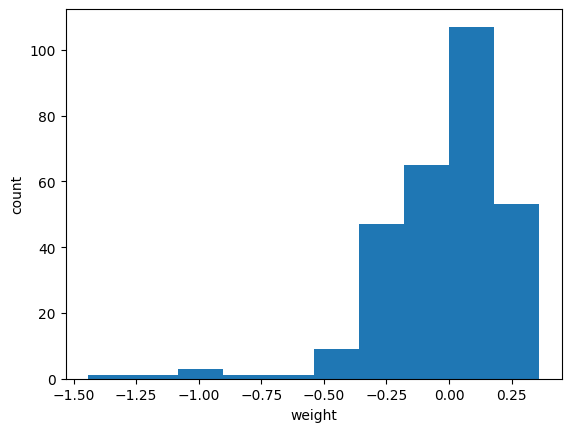

In [8]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

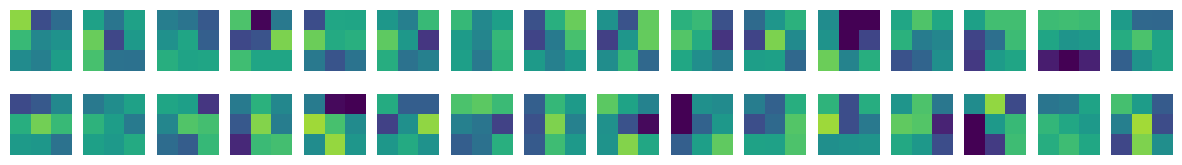

In [9]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

결과 그래프를 보면 가중치 값이 무작위로 나열된 것이 아닌 어떤 패턴을 볼 수 있음

참고로 밝은 부분의 값이 높음

첫번째 줄의 11번째 필터에서 위쪽의 3픽셀의 값이 높음

즉, 이 가중치는 직선을 만나면 크게 활성화됨

# 신경망의 가중치는 어떻게 선택될까

In [10]:
# 훈련하지 않은 빈 합성곱 신경망을 만들고 분석
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))
no_training_conv = no_training_model.layers[0] # 첫번째 층의 가중치를 변수에 저장

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [11]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std(), no_training_weights.max(), no_training_weights.min())

-0.010310263 0.0773888 0.14130606 -0.14113641


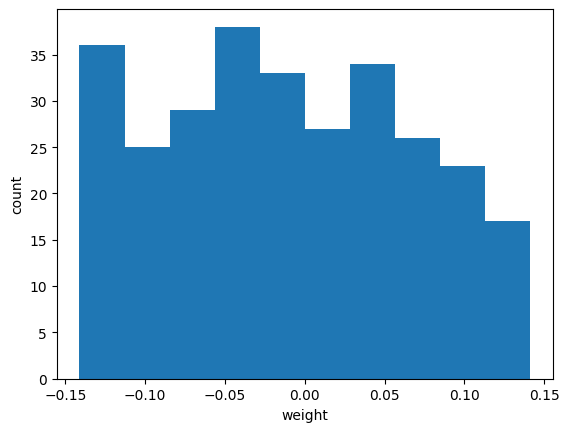

In [12]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

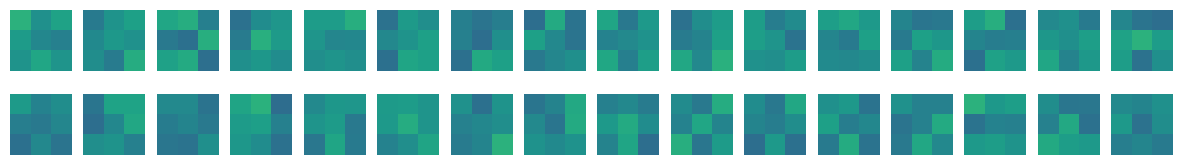

In [13]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

**함수형 API**
케라스 sequential 클래스: 층을 차례대로 쌓은 모델

딥러닝에서는 좀 더 복잡한 모델 존재

입력이 2개 or 출력이 2개

이러한 경우에 함수형 API를 사용

함수형 API는 케라스의 Model 클래스를 사용하여 모델을 만듬

예를 들어, 7장에서 만들었던 Dense 층 2개로 이루어진 완전 연결 신경망을 함수형 API로 구현

hidden = dense1(inputs)

파이썬의 모든 객체는 호출이 가능함

케라스의 층은 객체를 함수처럼 호출했을 때 적절히 동작할 수 있도록 미리 준비

위 코드는 입력값 inputs를 Dense 층에 통과



마지막: model = keras.Model(inputs, outputs)

inputs란

8-2에서 ploy_model()함수로 모델의 층을 도식화 했을 때 InputLayer 클래스가 처음에 나옴

Sequential 클래스는 inputLayer클래스를 자동으로 추가하고 호출

그러나 Model 클래스에서는 수동으로 만들어서 호출해야함

이 input이 InputLayer 클래스의 출력값이 되어야함

Sequential 클래스에서 InputLayer의 객체는 어디에 저장되는가

케라스 모델은 layers 속성 외에 InputLayer 객체를 포함한 _self_tracked_tracables 리스트 속성을 가지고 있음

Sequential 클래스 객체의 _self_tracked_trackables 속성의 첫번째 항목이 InputLayer 클래스의 객체임

InputLayer 클래스는

In [15]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [16]:
conv_acti = keras.Model(model.input, model.layers[0].output)

In [17]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


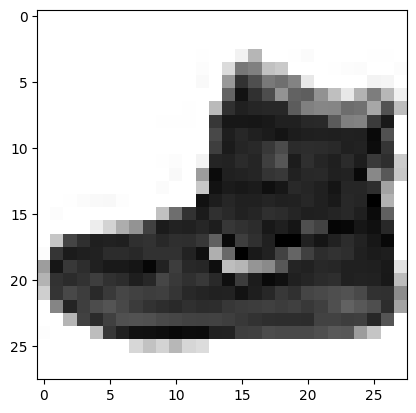

In [18]:
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [19]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0

feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 8s 8s/step


In [20]:
print(feature_maps.shape)

(1, 28, 28, 32)


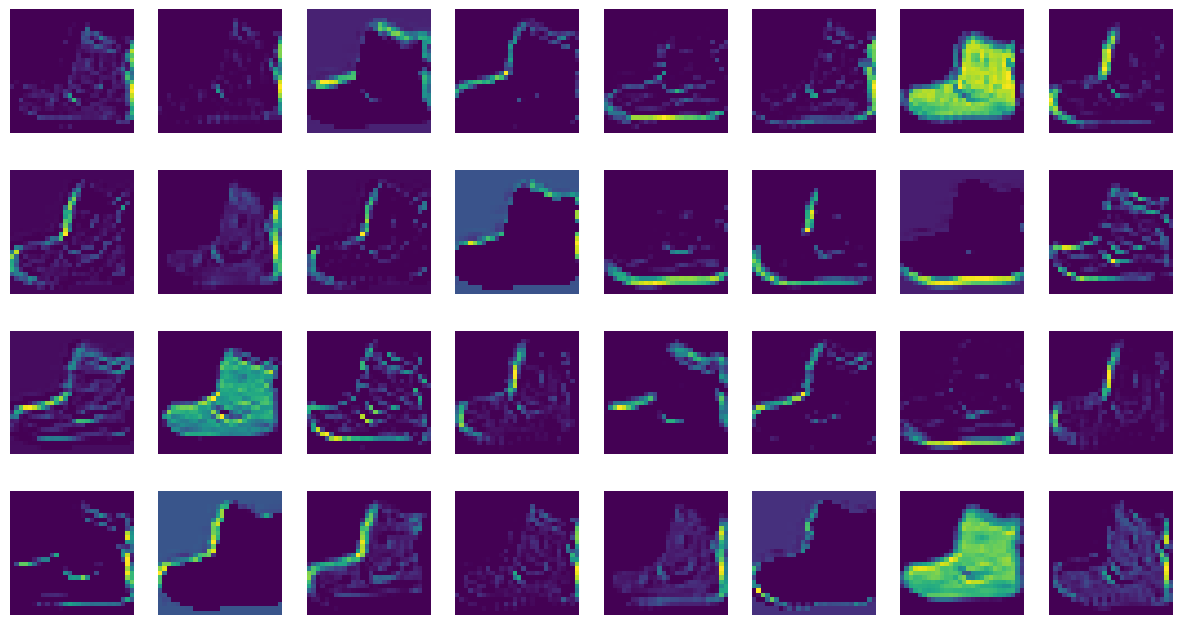

In [21]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

In [22]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [23]:
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)

1/1 [==============================] - 0s 68ms/step


In [24]:
print(feature_maps.shape)

(1, 14, 14, 64)


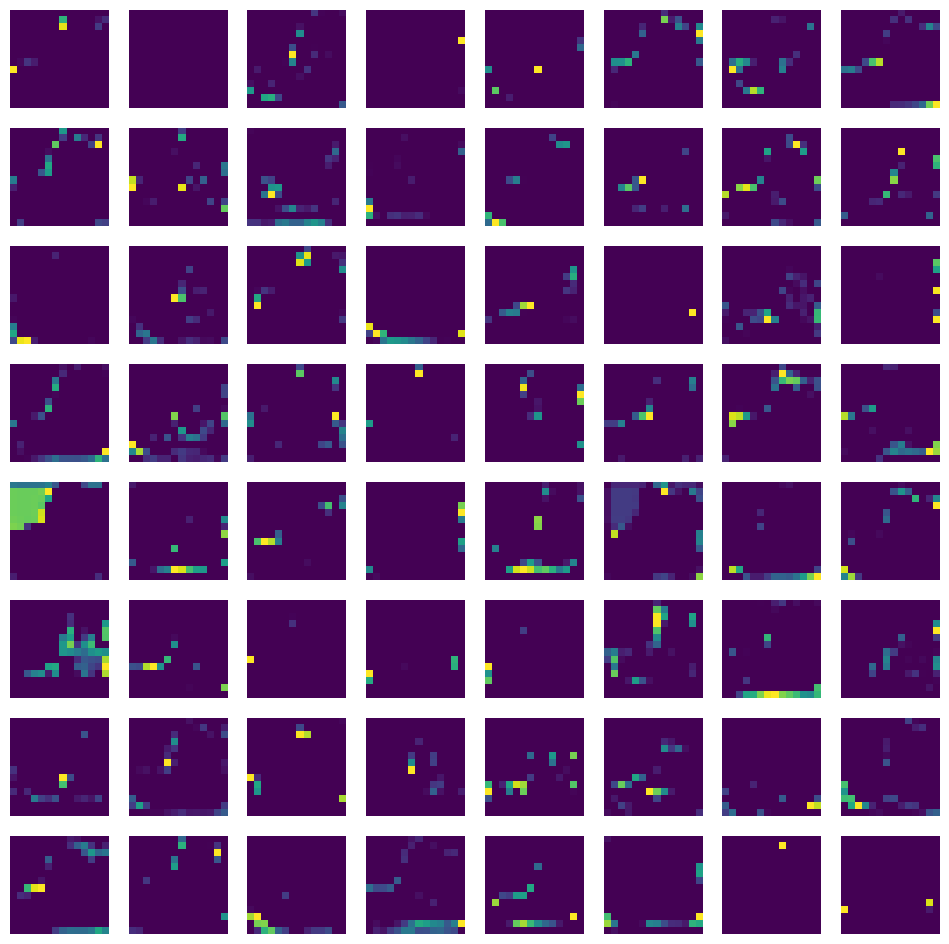

In [25]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

시각적으로 이해하기 힘듬

두번째 합성곱 층의 필터 크기는 (3,3,32)

두번째 합성곱 층의 첫번째 필터가 앞서 출력한 32개의 특성맵과 곱해져서 두번째 합성곱 층의 첫번째 특성 맵이 됨

이렇게 계산된 출력은 (14,14,32) 특성 맵에서 어떤 부위를 감지하는지 직관적으로 이해하기 어려움

이러한 현상은 합성곱 층을 많이 쌓을수록 심해짐

이를 바꾸어 생각하면 합성곱 신경망의 앞부분에 있는 합성곱 층은 이미지의 시각적인 정보를 감지하고 뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습한다고 볼 수 있음